# Assignment to do list
* gather daily prices for 3 stocks
* spilt the data into dataframes for each month
* get the singular values for each month and place them into a new df
* create a 3D scatter plot of the data
* perform a k-means cluster on data and plot them in different colors
* Perform PCA on each cluster to get the principal axis of each cluster
* plot an ellipsoid around each cluster 

In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
from sklearn.cluster import KMeans

import plotly
import plotly.express as px
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

In [2]:
# set path to folder we need data from
path = './data/daily/'

In [3]:
# get file names from files in daily folder
names = [ file[:-4] for file in os.listdir(path) if file.endswith('.csv') ]
# print out file names
print(names)

['googl_daily', 'goog_daily', 'msft_daily', 'amzn_daily', 'fb_daily', 'aapl_daily', 'baba_daily']


In [4]:
def only_price(stocks, n=3):
    """
    takes a list of stock symbls and the n number of symbls needed,
    randomly picks n symbls from the list,
    loops through the choose symbls and loads the data for that symbl into a dataframe,
    drops all columns other than date and price,
    concats all of the dataframes into one dataframe.
    returns a dataframe with the daily prices of the selected stocks.
    
    symbls: list, stock symbls should match files names of the data.
    n: int, number of symbls you want to use, default = 3.
    
    return: prices dataframe df, index = date, cols = prices for selected stocks
    """
    # change this seed or remvoe to get different symbls, used for reproducibility 
    random.seed(42)
    
    # select n symbls from the list
    stocks = random.sample(stocks, k=n)
    
    # create list to hold df's
    dfs = []
    
    # loop through symbls, load data, append to list of dfs
    for i in range(len(stocks)):
        stock = (
            pd.read_csv(f'./data/daily/{stocks[i]}.csv')
            .drop(columns=['Volume', 'SMAVG (15)'])
            .rename(columns={'Last Price': f'{stocks[i]}_price'})
            .set_index(['Date'])
        )
        dfs.append(stock)

    # create one dataframe from list of dataframes, reverse order so oldest data first
    df = pd.concat(dfs, axis=1).iloc[::-1]

    return df

In [5]:
# create df of daily prices from 3 stocks
prices = only_price(names, 3)

# print
prices.head()

aapl_daily_price  googl_daily_price  baba_daily_price
Date                                                            
1/9/2015             112.01             500.72            103.02
1/12/2015            109.25             497.06            101.62
1/13/2015            110.22             501.80            100.77
1/14/2015            109.80             505.93             99.58
1/15/2015            106.82             504.01             96.31

In [6]:
prices.index = pd.to_datetime(prices.index)

In [7]:
prices.index

DatetimeIndex(['2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-20', '2015-01-21',
               '2015-01-22', '2015-01-23',
               ...
               '2020-01-16', '2020-01-17', '2020-01-21', '2020-01-22',
               '2020-01-23', '2020-01-24', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30'],
              dtype='datetime64[ns]', name='Date', length=1273, freq=None)

In [8]:
prices_pct = prices.pct_change().dropna()
prices_pct.head()

aapl_daily_price  googl_daily_price  baba_daily_price
Date                                                             
2015-01-12         -0.024641          -0.007309         -0.013590
2015-01-13          0.008879           0.009536         -0.008364
2015-01-14         -0.003811           0.008230         -0.011809
2015-01-15         -0.027140          -0.003795         -0.032838
2015-01-16         -0.007770           0.012787          0.006022

In [9]:
years = prices_pct.index.year.unique()
months = prices_pct.index.month.unique()

In [10]:
dfs = []

for year in years:
    year = prices_pct[prices_pct.index.year == year]
    for month in months:
        month = year[year.index.month == month]
        dfs.append(month)

In [11]:
dfs = dfs[:61]

## SVD components
Let A = U Sigma V^T

* where A is a real m x n matrix that we want to decompose
* U is an m x m matrix, left singular vectors, eigenvectors of AA^T
* Sigma is an m x n diagonal matrix with singular values along the diagon
* V^T is the transpose of an n x n matrix V 

In [12]:
sigmas = []

for df in dfs:
    A = np.array(df)
    U,s,VT = svd(A)
    sigmas.append(s)

In [13]:
sigmas[:5]

[array([0.12089914, 0.08969113, 0.06969459]),
 array([0.06956467, 0.05446383, 0.04491782]),
 array([0.07848259, 0.07256635, 0.04180098]),
 array([0.08423681, 0.05331151, 0.03883203]),
 array([0.10348489, 0.06431043, 0.02201893])]

In [14]:
sigmas_df = pd.DataFrame(np.row_stack(sigmas))

In [15]:
sigmas_df

0         1         2
0   0.120899  0.089691  0.069695
1   0.069565  0.054464  0.044918
2   0.078483  0.072566  0.041801
3   0.084237  0.053312  0.038832
4   0.103485  0.064310  0.022019
..       ...       ...       ...
56  0.099085  0.056976  0.027784
57  0.110448  0.060423  0.033181
58  0.069869  0.043202  0.027069
59  0.070773  0.033509  0.027543
60  0.111317  0.037605  0.027408

[61 rows x 3 columns]

In [16]:
sigmas_df.rename(columns={0: 'aapl', 1: 'googl', 2: 'baba'}, inplace=True)

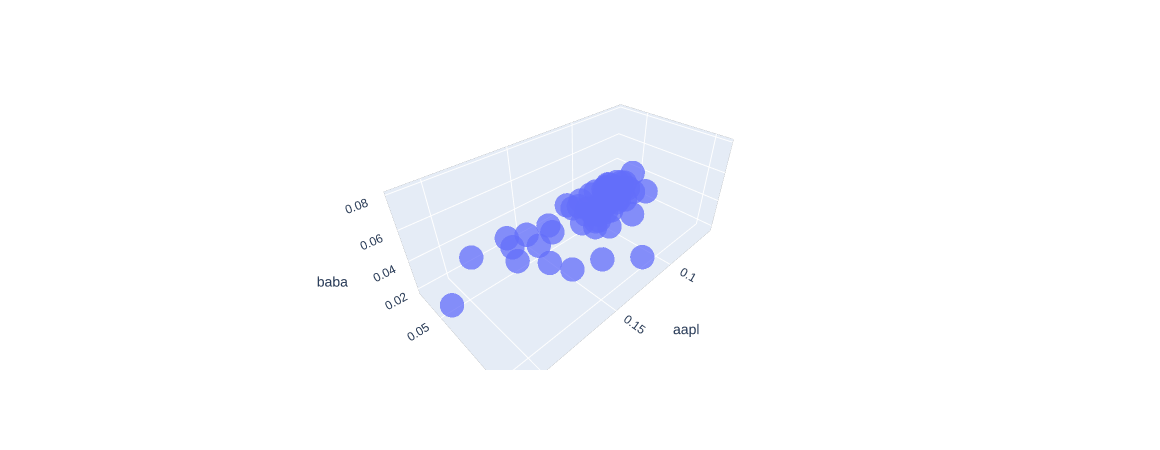

In [19]:
fig = px.scatter_3d(
    x = sigmas_df['aapl'],
    y = sigmas_df['googl'],
    z = sigmas_df['baba'],
    opacity=0.75
)
fig.update_layout(
    scene = dict(xaxis_title='aapl', yaxis_title='googl', zaxis_title='baba')
)
fig.show()

## K-means cluster

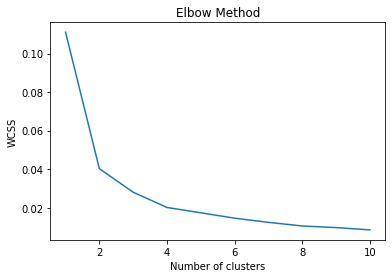

In [20]:
X = sigmas_df

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show();


In [21]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
X['cluster'] = pd.Series(kmeans.fit_predict(X))

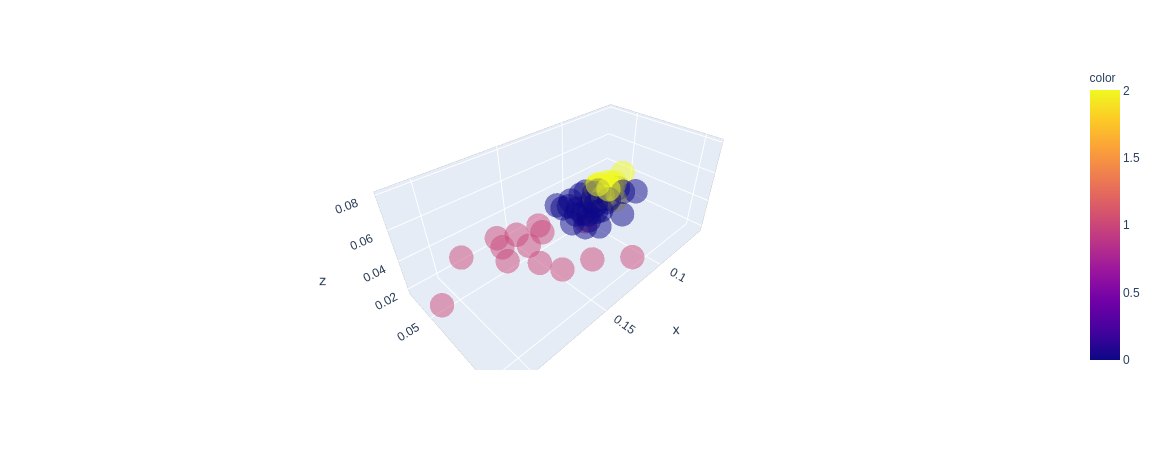

In [23]:
fig = px.scatter_3d(
    x = sigmas_df['aapl'],
    y = sigmas_df['googl'],
    z = sigmas_df['baba'],
    color=sigmas_df['cluster'],
    opacity=0.5
)

fig.show()

In [24]:
cluster1 = X.loc[X['cluster'] == 0]
cluster2 = X.loc[X['cluster'] == 1]
cluster3 = X.loc[X['cluster'] == 2]

scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.as_matrix()[:,0], y = cluster1.as_matrix()[:,1], z = cluster1.as_matrix()[:,2],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.as_matrix()[:,0], y = cluster2.as_matrix()[:,1], z = cluster2.as_matrix()[:,2],
    marker = dict( size=2, color='blue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.as_matrix()[:,0], y = cluster3.as_matrix()[:,1], z = cluster3.as_matrix()[:,2],
    marker = dict( size=2, color='red')
)
cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.as_matrix()[:,0], y = cluster1.as_matrix()[:,1], z = cluster1.as_matrix()[:,2],
    color='green', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.as_matrix()[:,0], y = cluster2.as_matrix()[:,1], z = cluster2.as_matrix()[:,2],
    color='blue', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3.as_matrix()[:,0], y = cluster3.as_matrix()[:,1], z = cluster3.as_matrix()[:,2],
    color='red', showscale = True
)
layout = dict(
    title = 'Interactive Cluster Shapes in 3D',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2, scatter3, cluster1, cluster2, cluster3], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='mesh3d_sample')


/home/andrew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/andrew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/andrew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/andrew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/andrew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/andrew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.
